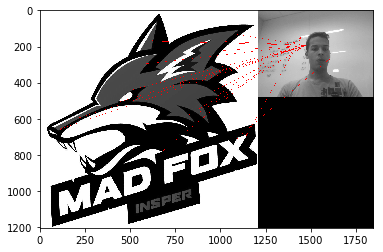

In [19]:
# -*- coding:utf-8 -*-
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time
# Adaptado da documentacao em http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
# Com a funcao drawMatches do usuario

def drawMatches(img1, kp1, img2, kp2, matches):
    """

    @author User rairyeng on StackOVerflow: http://stackoverflow.com/questions/20259025/module-object-has-no-attribute-drawmatches-opencv-python

    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated
    keypoints, as well as a list of DMatch data structure (matches)
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage

    #print(img2)


    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]


    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    #cv2.imshow('Matched Features', out)
    #cv2.waitKey(0)
    #cv2.destroyWindow('Matched Features')

    # Also return the image if you'd like a copy
    return out




MIN_MATCH_COUNT = 10

img1 = cv2.imread('madfox.png',0)
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)          # Imagem a procurar
img2 = cv2.imread('box_in_scene.png',0) # Imagem do cenario - puxe do video para fazer isto
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

ret, img2= cap.read() 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)   
#print(img2)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT in each image
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

# Configura o algoritmo de casamento de features
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Tenta fazer a melhor comparacao usando o algoritmo
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.6*n.distance:
        good.append(m)


if len(good)>MIN_MATCH_COUNT:
    # Separa os bons matches na origem e no destino
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)


    # Tenta achar uma trasformacao composta de rotacao, translacao e escala que situe uma imagem na outra
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Transforma os pontos da imagem origem para onde estao na imagem destino
    dst = cv2.perspectiveTransform(pts,M)

    # Desenha as linhas
    img2b = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    img3 = drawMatches(img1,kp1,img2,kp2,good[:20])

    plt.imshow(img3, 'gray'),plt.show()

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

cap.release()
